In [6]:
import pandas as pd

# CSV-Datei einlesen
telefonkunden = pd.read_csv('telefonkunden.csv')

# Die ersten paar Zeilen der Datei anzeigen
print(telefonkunden.head())

   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  


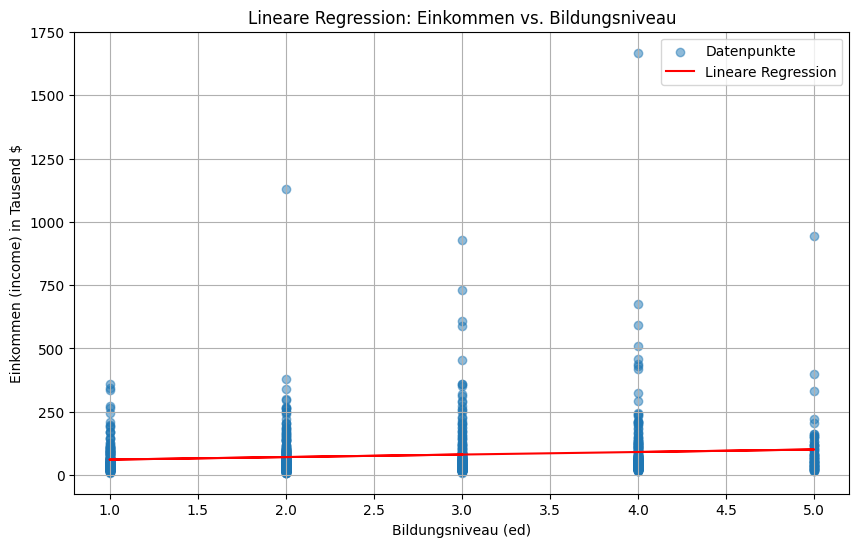

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Scatterplot der Datenpunkte
# Lineare Regression
X = telefonkunden[['ed']].values.reshape(-1, 1)
y = telefonkunden['income'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

# Plot der linearen Regression
plt.figure(figsize=(10, 6))
plt.scatter(telefonkunden['ed'], telefonkunden['income'], alpha=0.5, label='Datenpunkte')
plt.plot(telefonkunden['ed'], y_pred, color='red', label='Lineare Regression')
plt.title('Lineare Regression: Einkommen vs. Bildungsniveau')
plt.xlabel('Bildungsniveau (ed)')
plt.ylabel('Einkommen (income) in Tausend $')
plt.legend()
plt.grid(True)
plt.show()


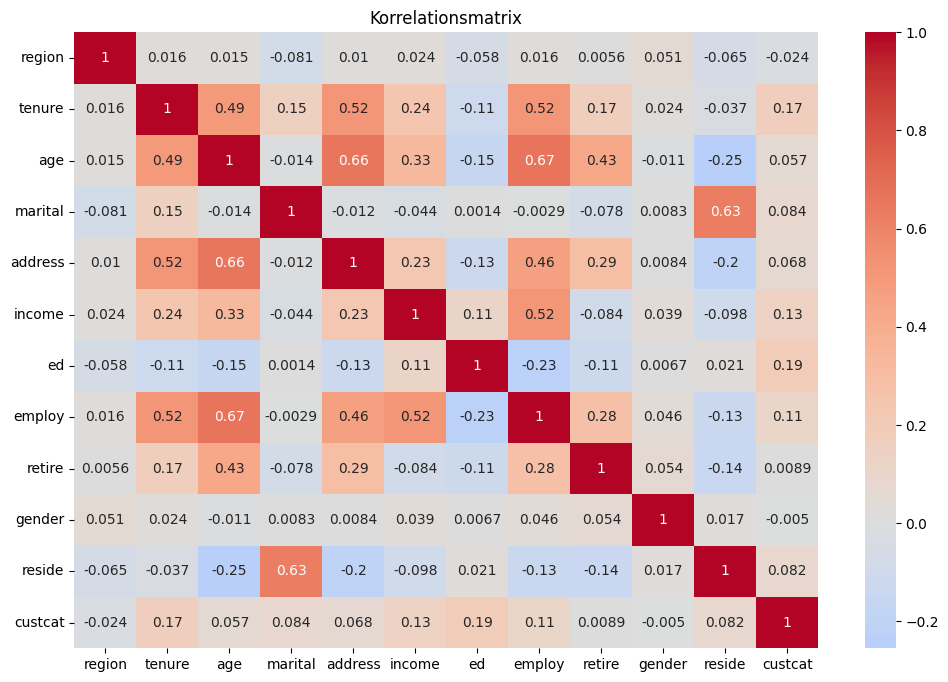

In [8]:
# Korrelationsmatrix
corr = telefonkunden.corr()
plt.figure(figsize=(12, 8))  # Größe der Figur anpassen
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix')
plt.show()

In [9]:
# Median berechnen und zur Tabelle hinzufügen
median = telefonkunden.median()
describe_df = telefonkunden.describe()
describe_df.loc['median'] = median
describe_df


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000
median,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000


Gender-Verteilung:
gender
1    517
0    483
Name: count, dtype: int64

Durchschnittliches Einkommen nach Gender:
gender
0    73.250518
1    81.537718
Name: income, dtype: float64


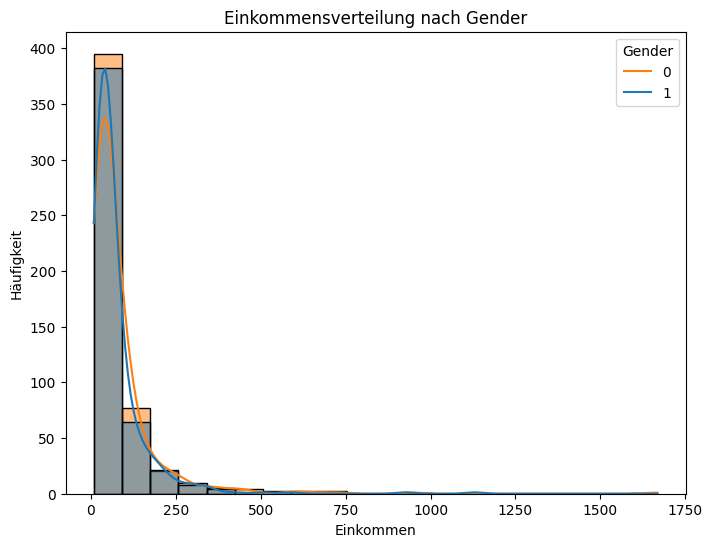

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Grundlegende Übersicht
print("Gender-Verteilung:")
print(telefonkunden['gender'].value_counts())

# Vergleich von Einkommen nach Gender
print("\nDurchschnittliches Einkommen nach Gender:")
print(telefonkunden.groupby('gender')['income'].mean())


# Histogramm: Verteilung von Einkommen nach Gender
plt.figure(figsize=(8, 6))
sns.histplot(data=telefonkunden, x='income', hue='gender', kde=True, bins=20)
plt.title('Einkommensverteilung nach Gender')
plt.xlabel('Einkommen')
plt.ylabel('Häufigkeit')
plt.legend(title='Gender', labels=['0', '1'])
plt.show()


Durchschnittliches Einkommen nach Kundengruppe:
custcat
1    54.759398
2    74.834101
3    89.032028
4    92.000000
Name: income, dtype: float64


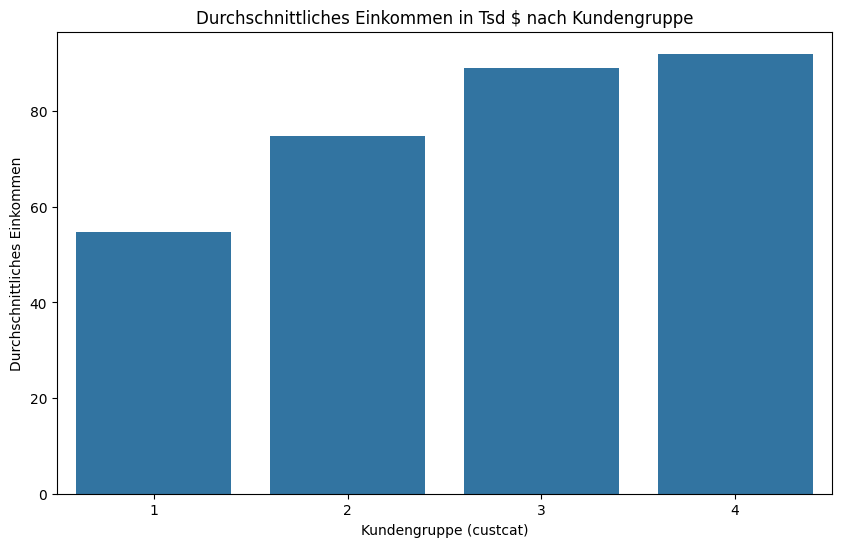

Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:
custcat
1    24.676692
2    43.345622
3    40.078292
4    35.144068
Name: tenure, dtype: float64


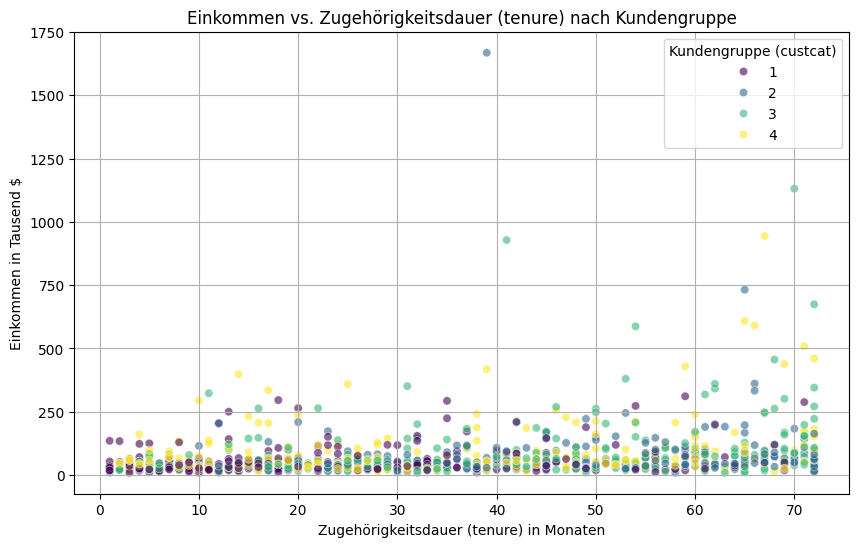

In [11]:
# Durchschnittliches Einkommen nach Kundengruppe (custcat) berechnen
avg_income_by_custcat = telefonkunden.groupby('custcat')['income'].mean()

# Ergebnis anzeigen
print("Durchschnittliches Einkommen nach Kundengruppe:")
print(avg_income_by_custcat)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_income_by_custcat.index, y=avg_income_by_custcat.values)
plt.title('Durchschnittliches Einkommen in Tsd $ nach Kundengruppe')
plt.xlabel('Kundengruppe (custcat)')
plt.ylabel('Durchschnittliches Einkommen')
plt.show()

# Durchschnittliche Zugehörigkeitsdauer (tenure) nach Kundengruppe berechnen
avg_tenure_by_custcat = telefonkunden.groupby('custcat')['tenure'].mean()

# Ergebnis anzeigen
print("Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:")
print(avg_tenure_by_custcat)

# Scatterplot mit Einkommen und tenure
plt.figure(figsize=(10, 6))
sns.scatterplot(x=telefonkunden['tenure'], y=telefonkunden['income'], hue=telefonkunden['custcat'], palette='viridis', alpha=0.6)
plt.title('Einkommen vs. Zugehörigkeitsdauer (tenure) nach Kundengruppe')
plt.xlabel('Zugehörigkeitsdauer (tenure) in Monaten')
plt.ylabel('Einkommen in Tausend $')
plt.legend(title='Kundengruppe (custcat)')
plt.grid(True)
plt.show()

In [12]:
# Durchschnittswerte der Merkmale je Servicekategorie berechnen
avg_features_by_custcat = telefonkunden.groupby('custcat').mean()

# Ausgabe in einer Tabelle
avg_features_by_custcat

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
custcat,,,,,,,,,,,
1,2.090226,24.676692,39.657895,0.417293,9.390977,54.759398,2.364662,8.484962,0.041353,0.507519,2.199248
2,1.963134,43.345622,41.788018,0.529954,12.571429,74.834101,2.958525,10.576037,0.032258,0.548387,2.336406
3,1.996441,40.078292,44.430605,0.494662,13.380783,89.032028,2.153025,14.309609,0.078292,0.505338,2.227758
4,2.029661,35.144068,40.601695,0.550847,10.868644,92.000000,3.368644,10.228814,0.029661,0.512712,2.597458


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop('custcat', axis=1)
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Feature-Selection: SelectKBest
k_best = SelectKBest(score_func=f_classif, k='all')
k_best.fit(X_training, Y_training)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': k_best.scores_})
print("Feature Scores using SelectKBest:")
print(feature_scores.sort_values(by='Score', ascending=False))

# Feature-Selection: Recursive Feature Elimination (RFE)
model = RandomForestClassifier(random_state=1)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_training, Y_training)
rfe_features = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
print("Feature Rankings using RFE:")
print(rfe_features.sort_values(by='Ranking'))

# Modelltraining und -bewertung mit den besten Features
selected_features = feature_scores.sort_values(by='Score', ascending=False)['Feature'].head(5).tolist()
X_train_selected = X_training[selected_features]
X_test_selected = X_test[selected_features]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected, Y_training)
Y_pred = knn.predict(X_test_selected)

print("Klassifikationsbericht mit ausgewählten Features:")
print(classification_report(Y_test, Y_pred))

Feature Scores using SelectKBest:
    Feature      Score
6        ed  53.817180
1    tenure  29.390559
7    employ  15.678875
4   address  10.281757
2       age   8.576518
5    income   5.774136
10   reside   4.634765
3   marital   2.695598
0    region   2.283164
8    retire   1.872375
9    gender   0.219995
Feature Rankings using RFE:
    Feature  Ranking
1    tenure        1
2       age        1
5    income        1
4   address        1
7    employ        1
6        ed        2
10   reside        3
0    region        4
9    gender        5
3   marital        6
8    retire        7
Klassifikationsbericht mit ausgewählten Features:
              precision    recall  f1-score   support

           1       0.36      0.45      0.40        53
           2       0.33      0.41      0.37        44
           3       0.29      0.29      0.29        56
           4       0.16      0.09      0.11        47

    accuracy                           0.31       200
   macro avg       0.29      0.31 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Merkmale und Zielvariable definieren
X = telefonkunden[['tenure','age','income','address','employ','ed']] # Merkmale, die für die Vorhersage von 'custcat' relevant sind
Y = telefonkunden['custcat']

# Daten in Trainings- und Testset aufteilen 80/20 Split|Stratified --> gleiche Verteilung der Zielvariable
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# KNN-Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=19)  # Anzahl der Nachbarn 
vorhersage_scikit = knn.fit(X_training, Y_training)

vorhersage_scikit = knn.predict(X_test)

# Genauigkeit der Vorhersage
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, vorhersage_scikit))

0.395


Text(0.5, 1.0, 'Genauigkeit in Abhängigkeit der Anzahl der Nachbarn')

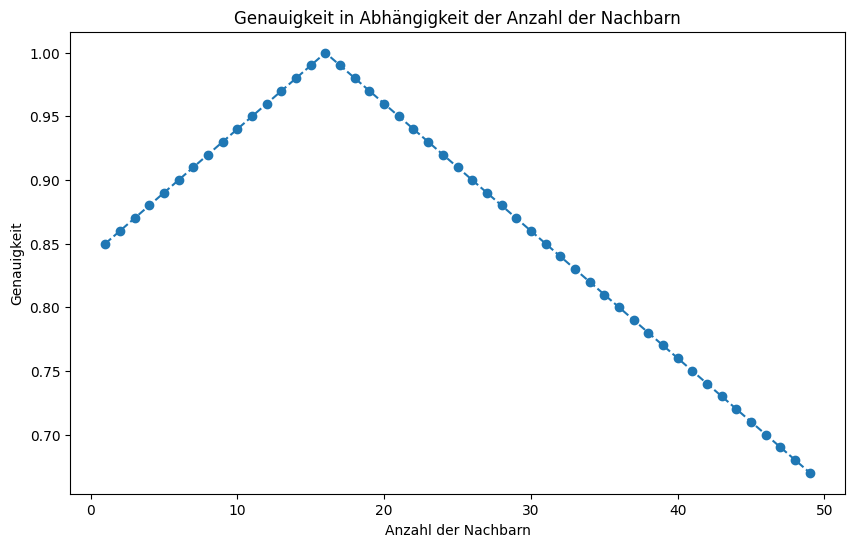

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 

plt.plot(np.arange(1, 50), scores, marker='o', linestyle='dashed')

plt.xlabel('Anzahl der Nachbarn')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit in Abhängigkeit der Anzahl der Nachbarn')

Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.43      0.42      0.42        53
           2       0.35      0.34      0.34        44
           3       0.34      0.36      0.35        56
           4       0.28      0.28      0.28        47

    accuracy                           0.35       200
   macro avg       0.35      0.35      0.35       200
weighted avg       0.35      0.35      0.35       200

Genauigkeit: 0.35


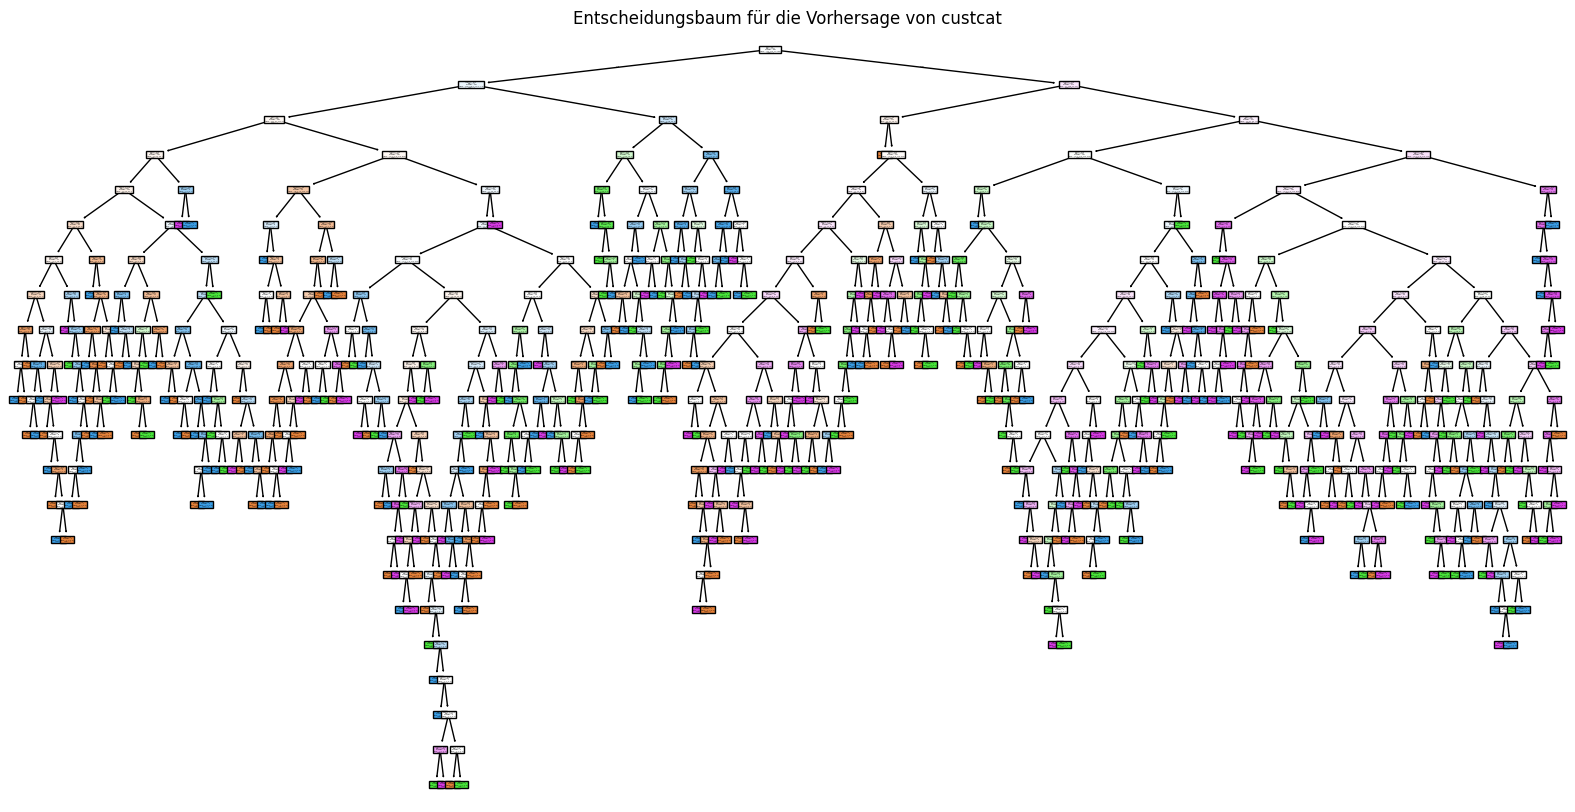

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Entscheidungsbaum-Modell erstellen und trainieren
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

# Vorhersagen machen
y_pred = tree.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Entscheidungsbaum visualisieren
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, class_names=[str(i) for i in tree.classes_], filled=True)
plt.title('Entscheidungsbaum für die Vorhersage von custcat')
plt.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[selected_features]
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_training, Y_training)

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter:", grid_search.best_params_)

# Entscheidungsbaum-Modell mit den besten Hyperparameter erstellen und trainieren
best_tree = grid_search.best_estimator_
best_tree.fit(X_training, Y_training)

# Vorhersagen machen
y_pred = best_tree.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(Y_test, y_pred))
print("Genauigkeit:", accuracy_score(Y_test, y_pred))

Beste Hyperparameter: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.41      0.42      0.41        53
           2       0.33      0.30      0.31        44
           3       0.29      0.32      0.30        56
           4       0.27      0.26      0.26        47

    accuracy                           0.33       200
   macro avg       0.32      0.32      0.32       200
weighted avg       0.33      0.33      0.32       200

Genauigkeit: 0.325


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt


# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop('custcat', axis=1)
y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Random Forest Modell
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Klassifikationsbericht:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Genauigkeit:", accuracy_score(y_test, y_pred_rf))

# Gradient Boosting Modell
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Klassifikationsbericht:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting Genauigkeit:", accuracy_score(y_test, y_pred_gb))

Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.50      0.53      0.51        53
           2       0.37      0.32      0.34        44
           3       0.37      0.43      0.40        56
           4       0.37      0.32      0.34        47

    accuracy                           0.41       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.40      0.41      0.40       200

Random Forest Genauigkeit: 0.405
Gradient Boosting Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.48      0.40      0.43        53
           2       0.37      0.36      0.37        44
           3       0.34      0.41      0.37        56
           4       0.40      0.38      0.39        47

    accuracy                           0.39       200
   macro avg       0.40      0.39      0.39       200
weighted avg       0.40      0.39      0.39       200

Gradient Boosting

In [25]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Beste Hyperparameter für Random Forest:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Beste Random Forest Klassifikationsbericht:")
print(classification_report(y_test, y_pred_best_rf))
print("Beste Random Forest Genauigkeit:", accuracy_score(y_test, y_pred_best_rf))

Beste Hyperparameter für Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Beste Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.47      0.53      0.50        53
           2       0.42      0.32      0.36        44
           3       0.32      0.38      0.35        56
           4       0.43      0.38      0.40        47

    accuracy                           0.41       200
   macro avg       0.41      0.40      0.40       200
weighted avg       0.41      0.41      0.40       200

Beste Random Forest Genauigkeit: 0.405


In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Kreuzvalidierungsscores für Random Forest:", scores)
print("Durchschnittliche Kreuzvalidierungsgenauigkeit für Random Forest:", scores.mean())

Kreuzvalidierungsscores für Random Forest: [0.3875  0.475   0.39375 0.33125 0.38125]
Durchschnittliche Kreuzvalidierungsgenauigkeit für Random Forest: 0.39375
